<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts")
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は場合分けをせず、時系列分析します。

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [14]:
#ライブラリインストール(必要に応じて)
#install.packages( "tidyverse" )
#install.packages( "fable" )
#install.packages( "urca" )
#install.packages( "reshape2" )

# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )

repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) ->   # ネット上のファイル読み込み
pop_df


# 手順２　データの可視化

まず、データをプロットしてみます。

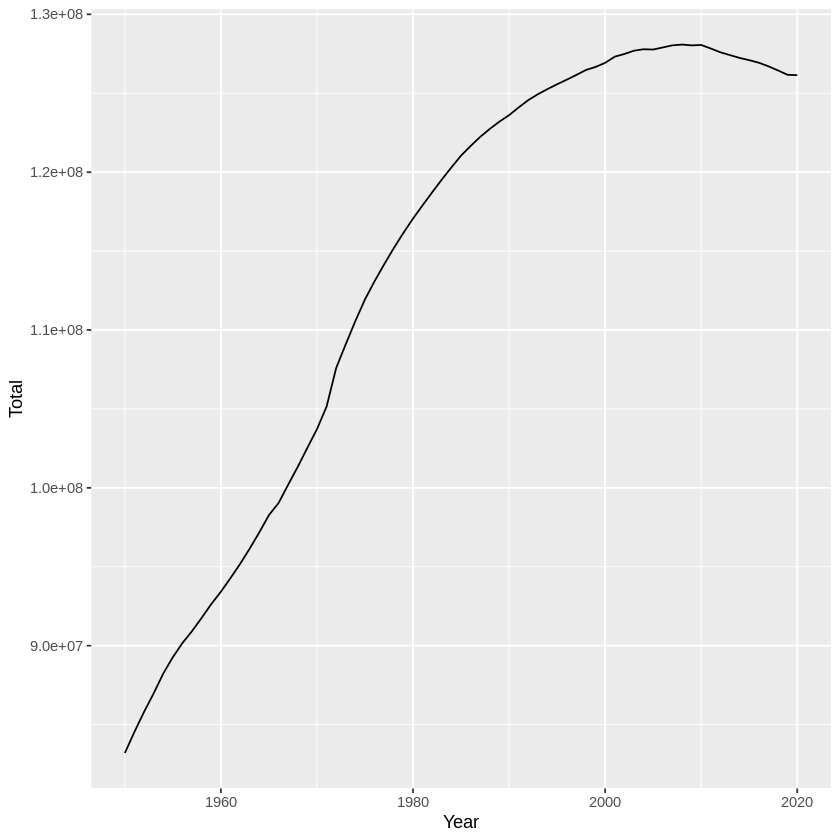

In [3]:
# ライブラリの読み込み
library( ggplot2 )

# 総人口のグラフ
pop_df |>
  ggplot( aes( x = Year,
               y = Total )) +
  geom_line()

次に、自己相関を確認してみます。

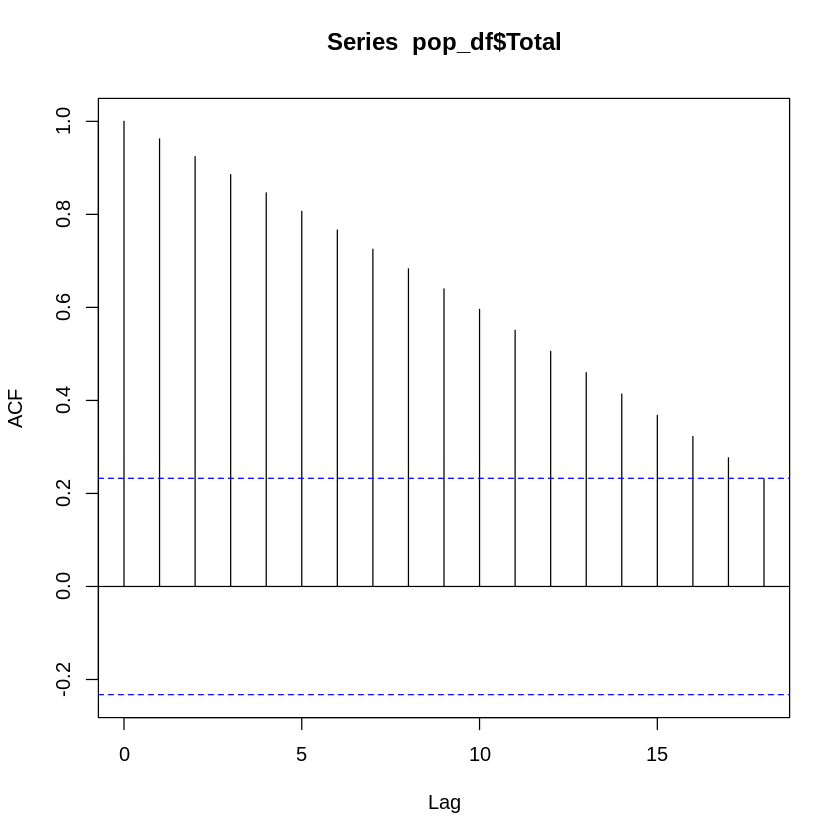

In [4]:
# 自己相関のグラフ
pop_df$Total |>
  acf()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

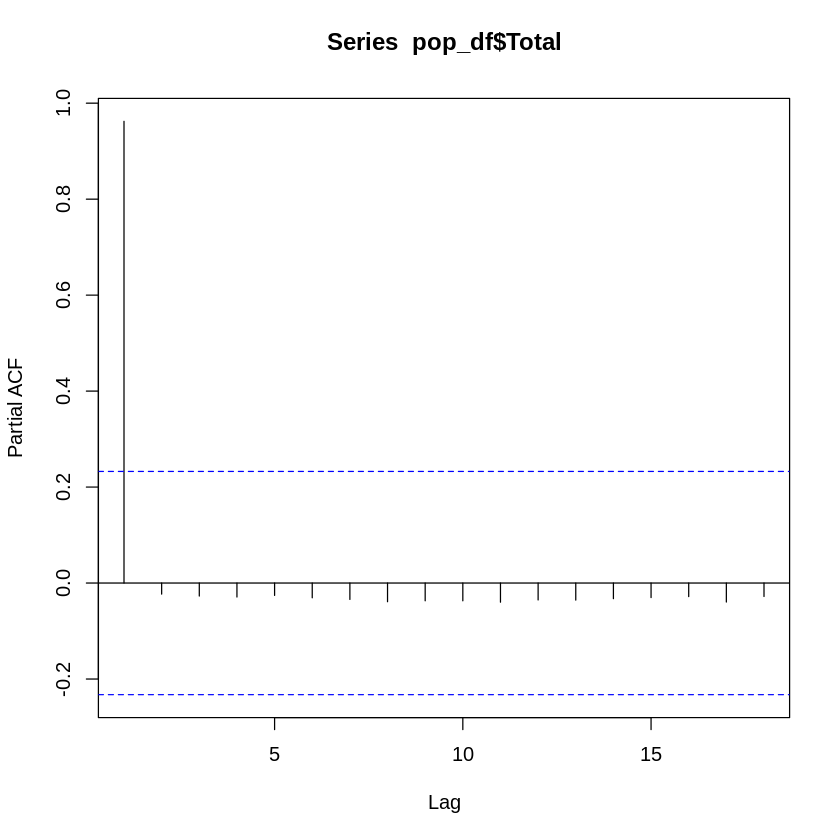

In [5]:
# 偏自己相関のグラフ
pop_df$Total |>
  pacf() 

# 手順３　学習データと予測データの分類

２０１５年までのデータを学習データとし、その後５年間のデータを予測データとします。

In [6]:
# 学習データと予測データ
prow_test = 5

pop_df |>
  tail( n = prow_test ) ->
pop_test

# ライブラリの読み込み
library( fable )

pop_df |>
  head( n = { nrow( pop_df ) - prow_test }) |>
  as_tsibble( index = Year ) -> 
pop_train

Loading required package: fabletools

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# 手順４　ＡＲＩＭＡモデルによる予測

学習データを使ってＡＲＩＭＡモデルを推定していきます。  
まず、モデルを自動推定させ、ＡＩＣが＋２までのモデルを候補にします。

In [15]:
# ライブラリの読み込み
library( dplyr )

# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train |>
    model(
      arima = ARIMA( Total,
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
  }) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arima

max_AIC = min( trace_arima$AIC ) + 2
trace_arima |>
  filter( AIC < max_AIC ) 

Warning message:
“6 parsing failures.
row col  expected    actual         file
 17 AIC a number  Inf       literal data
 27 AIC a number  A         literal data
 27 NA  2 columns 6 columns literal data
 28 NA  2 columns 1 columns literal data
 29 NA  2 columns 1 columns literal data
... ... ......... ......... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(1,2,0)(0,0,0)[1]",1747.395
"ARIMA(2,2,0)(0,0,0)[1]",1748.376
"ARIMA(0,2,1)(0,0,0)[1]",1746.738
"ARIMA(1,2,1)(0,0,0)[1]",1748.709
"ARIMA(2,2,1)(0,0,0)[1]",1747.343
"ARIMA(0,2,2)(0,0,0)[1]",1748.690


列挙されたモデルで５年後までを予測し、  
２０２０年の実測人口に最も近いモデルを採用することにします。

In [16]:
# 予測
pop_train |>
  model(
    arima120 = ARIMA( Total ~ 0 + pdq( 1, 2, 0 )),
    arima220 = ARIMA( Total ~ 0 + pdq( 2, 2, 0 )), 
    arima021 = ARIMA( Total ~ 0 + pdq( 0, 2, 1 )),
    arima121 = ARIMA( Total ~ 0 + pdq( 1, 2, 1 )),
    arima221 = ARIMA( Total ~ 0 + pdq( 2, 2, 1 )),
    arima022 = ARIMA( Total ~ 0 + pdq( 0, 2, 2 ))) |>
  forecast( h = "5 years" ) ->
pop_arima_f

pop_arima_f |>
  filter( Year == 2020 ) 
pop_test |>
  select( Year, Total ) |>
  tail( 1 )

.model,Year,Total,.mean
<chr>,<dbl>,<dist>,<dbl>
arima120,2020,"N(1.3e+08, 1.5e+12)",126343861
arima220,2020,"N(1.3e+08, 1.3e+12)",126328262
arima021,2020,"N(1.3e+08, 1.3e+12)",126323900
arima121,2020,"N(1.3e+08, 1.3e+12)",126325699
arima221,2020,"N(1.3e+08, 1.4e+12)",126279205
arima022,2020,"N(1.3e+08, 1.3e+12)",126327469


Year,Total
<dbl>,<dbl>
2020,126146000


ＡＲＩＭＡ（２，２，１）を採用する事にします。

# 手順５　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126917249,126838000,126864000,126912000,126938000
2017,126706000,126769685,126532000,126605000,126704000,126777000
2018,126443000,126598854,126177000,126315000,126441000,126580000
2019,126167000,126445014,125773000,125998000,126125000,126351000
2020,126146000,126279205,125325000,125658000,125761000,126094000


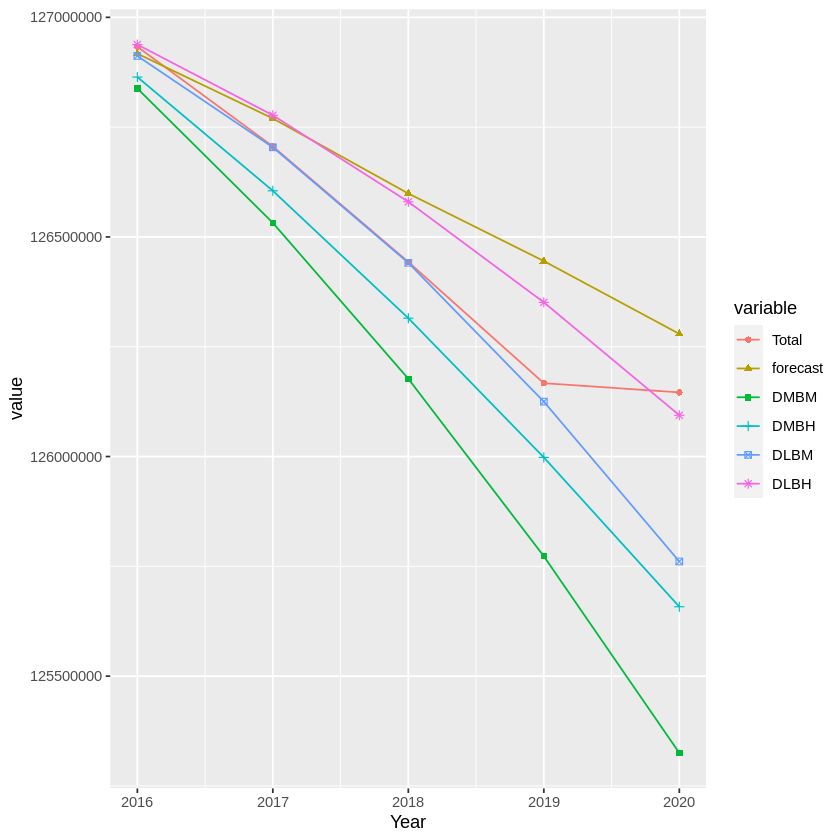

In [17]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) ->           # ＴＳＩＢＢＬＥライブラリに変換
ipss_test

pop_arima_f |>
  as.data.frame() |>
  filter( .model == "arima221" ) |>
  select( Year, "forecast" = .mean ) |>
  inner_join( pop_test, by = "Year" ) |>
  inner_join( ipss_test, by = "Year" )|>
  select( Year,
          Total,
          forecast,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test
join_test

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test |> 
  melt(id = "Year",
       measure = c( "Total",
                    "forecast",
                    "DMBM",
                    "DMBH",
                    "DLBM",
                    "DLBH")) |>
  ggplot( aes( x = Year,
               y = value,
               shape = variable,
               colour = variable,
               group = variable )) +
  geom_line() +
  geom_point()

どうやら、実データより１０万人強、高く予測してしまったようです。  
人口変動の要因は一つではないので、もう少し細かいモデルが必要のようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　[ Python_ARIMA_1 ](https://colab.research.google.com/drive/1--2tl9CaoS7YWa9YM9-K7kTxgimLVrVx?usp=sharing)
*   同じ事を状態空間モデルでやってみる。　->　[ R_StateSpace_1 ](https://colab.research.google.com/drive/1S1ZznBv9BpDVXPgi6C03jic6BDOGKSCA?usp=sharing)
*   人口方程式の考え方に沿ってみる　->　[ R_ARIMA_2 ](https://colab.research.google.com/drive/1EF1ngKafPHpPy1QcZHBZ_8wmvGunLWbK?usp=sharing)
